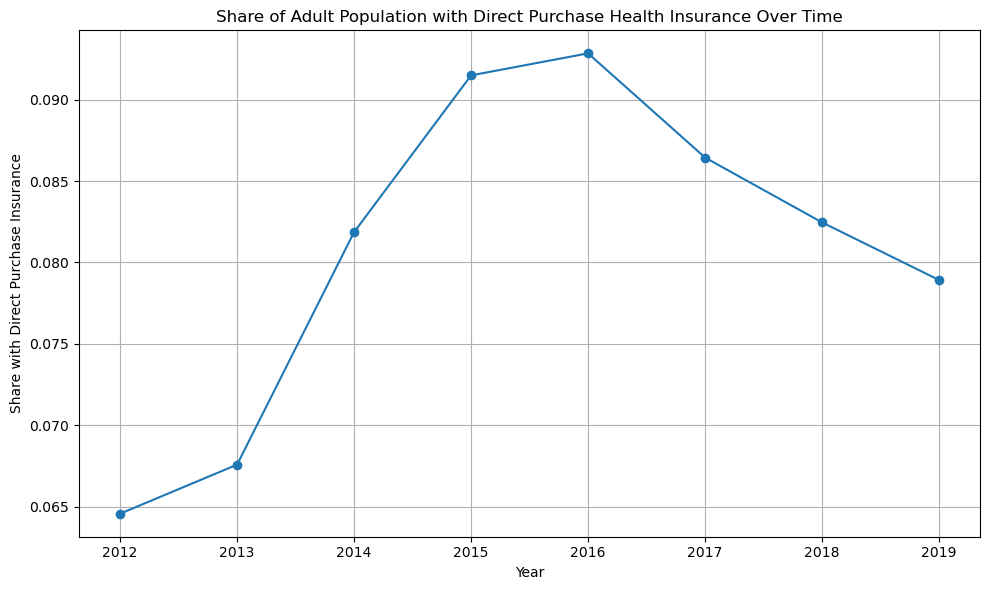

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Question 1 
insurance_data = pd.read_csv("/Users/avanthpakanati/Desktop/ECON:HLTH Research Seminar /Homework5/data/Output/acs_insurance.txt", sep="\t")

# Calculate the share of adults with direct purchase insurance
insurance_data['direct_share'] = insurance_data['ins_direct'] / insurance_data['adult_pop']

# Group by year and sum across all states
national_share = insurance_data.groupby('year')[['ins_direct', 'adult_pop']].sum()

# Calculate national share of direct purchase insurance
national_share['direct_share'] = national_share['ins_direct'] / national_share['adult_pop']

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(national_share.index, national_share['direct_share'], marker='o')
plt.title('Share of Adult Population with Direct Purchase Health Insurance Over Time')
plt.xlabel('Year')
plt.ylabel('Share with Direct Purchase Insurance')
plt.grid(True)
plt.tight_layout()
plt.show()





In [18]:
#Question 2

Index(['State', 'year', 'adult_pop', 'ins_employer', 'ins_direct',
       'ins_medicare', 'ins_medicaid', 'uninsured', 'direct_share'],
      dtype='object')


In [20]:
#Question 3 

insurance_data['medicaid_share'] = insurance_data['ins_medicaid'] / insurance_data['adult_pop']
medicaid_national_share = insurance_data.groupby('year')[['ins_medicaid', 'adult_pop']].sum()

medicaid_national_share['medicaid_share'] = medicaid_national_share['ins_medicaid'] / medicaid_national_share['adult_pop']
